# F1 Modern-Era Analysis — Data Preparation & Exploratory Analysis

This notebook performs data preparation and exploratory data analysis (EDA) for modern-era Formula 1 race data.  
The goal of this analysis is **not limited to a specific Grand Prix**, but instead establishes a reusable and extensible workflow applicable to any future prediction task.

### Objectives of this notebook
- Load and clean multi-season F1 race data  
- Standardize core fields (drivers, teams, results, timing)  
- Explore modern-era performance trends (drivers, teams, grid impact, race outcomes)  
- Generate insights that will feed into:
  - Feature engineering (seasonal & recent-form metrics)
  - Clustering analysis
  - Modeling and win-probability prediction
  - SHAP-based model interpretation

This notebook serves as the foundation for all downstream F1 analytics work.

In [106]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [107]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jtrotman/formula-1-race-data")

print("Path to dataset files:", path)

Path to dataset files: /Users/minseobeom/.cache/kagglehub/datasets/jtrotman/formula-1-race-data/versions/110


In [108]:
from pathlib import Path

base_dir = Path(path)
print("Base dir:", base_dir)

# List all files and subdirectories
for p in base_dir.rglob("*"):
    print(p)

Base dir: /Users/minseobeom/.cache/kagglehub/datasets/jtrotman/formula-1-race-data/versions/110
/Users/minseobeom/.cache/kagglehub/datasets/jtrotman/formula-1-race-data/versions/110/circuits.csv
/Users/minseobeom/.cache/kagglehub/datasets/jtrotman/formula-1-race-data/versions/110/status.csv
/Users/minseobeom/.cache/kagglehub/datasets/jtrotman/formula-1-race-data/versions/110/lap_times.csv
/Users/minseobeom/.cache/kagglehub/datasets/jtrotman/formula-1-race-data/versions/110/sprint_results.csv
/Users/minseobeom/.cache/kagglehub/datasets/jtrotman/formula-1-race-data/versions/110/drivers.csv
/Users/minseobeom/.cache/kagglehub/datasets/jtrotman/formula-1-race-data/versions/110/races.csv
/Users/minseobeom/.cache/kagglehub/datasets/jtrotman/formula-1-race-data/versions/110/constructors.csv
/Users/minseobeom/.cache/kagglehub/datasets/jtrotman/formula-1-race-data/versions/110/constructor_standings.csv
/Users/minseobeom/.cache/kagglehub/datasets/jtrotman/formula-1-race-data/versions/110/qualifyi

## STEP 1 — Load Raw Kaggle Files

In [109]:
from pathlib import Path
import pandas as pd

# 1) Try KaggleHub cache (your local)
kagglehub_path = Path.home() / ".cache/kagglehub/datasets/jtrotman/formula-1-race-data/versions/110"

# 2) If not found, try project raw folder
PROJECT_ROOT = Path().resolve().parent
RAW_DIR = PROJECT_ROOT / "data" / "raw"

if kagglehub_path.exists():
    print("Using KaggleHub cache folder")
    base_dir = kagglehub_path
else:
    print("Using local raw folder in repository")
    base_dir = RAW_DIR

results = pd.read_csv(base_dir / "results.csv")
races = pd.read_csv(base_dir / "races.csv")
drivers = pd.read_csv(base_dir / "drivers.csv")
constructors = pd.read_csv(base_dir / "constructors.csv")
status = pd.read_csv(base_dir / "status.csv")

print(results.head())
print(results.columns)

Using KaggleHub cache folder
   resultId  raceId  driverId  constructorId number grid position  \
0         1      18         1              1     22    1        1   
1         2      18         2              2      3    5        2   
2         3      18         3              3      7    7        3   
3         4      18         4              4      5   11        4   
4         5      18         5              1     23    3        5   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   
2            3              3     6.0    58       +8.163      5698779   
3            4              4     5.0    58      +17.181      5707797   
4            5              5     4.0    58      +18.014      5708630   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0         39    2       1:27.452           218.3        

## STEP 2 — Merge Datasets Into a Single Race-Result Table

In [110]:
# Merge results with race metadata
race_results = (
    results
    .merge(
        races[["raceId", "year", "round", "name", "circuitId", "date"]],
        on="raceId",
        how="left"
    )
    .merge(
        drivers[["driverId", "code", "forename", "surname"]],
        on="driverId",
        how="left"
    )
    .merge(
        constructors[["constructorId", "name"]].rename(columns={"name": "team"}),
        on="constructorId",
        how="left"
    )
    .merge(
        status[["statusId", "status"]],
        on="statusId",
        how="left"
    )
)

race_results = race_results.rename(
    columns={
        "year": "season",
        "name": "grand_prix",
        "date": "race_date",
        "position": "finish_position",
    }
)

print("Merged race_results shape:", race_results.shape)
race_results.head()

Merged race_results shape: (27218, 28)


,resultId,raceId,driverId,constructorId,number,grid,finish_position,positionText,positionOrder,points,...,season,round,grand_prix,circuitId,race_date,code,forename,surname,team,status
0,1,18,1,1,22,1,1,1,1,10.0,...,2008,1,Australian Grand Prix,1,2008-03-16,HAM,Lewis,Hamilton,McLaren,Finished
1,2,18,2,2,3,5,2,2,2,8.0,...,2008,1,Australian Grand Prix,1,2008-03-16,HEI,Nick,Heidfeld,BMW Sauber,Finished
2,3,18,3,3,7,7,3,3,3,6.0,...,2008,1,Australian Grand Prix,1,2008-03-16,ROS,Nico,Rosberg,Williams,Finished
3,4,18,4,4,5,11,4,4,4,5.0,...,2008,1,Australian Grand Prix,1,2008-03-16,ALO,Fernando,Alonso,Renault,Finished
4,5,18,5,1,23,3,5,5,5,4.0,...,2008,1,Australian Grand Prix,1,2008-03-16,KOV,Heikki,Kovalainen,McLaren,Finished


## STEP 3 — Clean and Standardize Core Columns

In [111]:
import numpy as np

# 1. Create a short driver label, preferring 'code' when available
race_results["driver"] = race_results["code"]

mask_no_code = race_results["driver"].isna()
race_results.loc[mask_no_code, "driver"] = (
    race_results.loc[mask_no_code, "forename"].str[0] + ". " + race_results.loc[mask_no_code, "surname"]
)

# 2. Convert grid to numeric (coerce errors to NaN, then 0, then int)
race_results["grid"] = pd.to_numeric(race_results["grid"], errors="coerce").fillna(0).astype(int)

# 3. Preserve raw finish_position as separate column
race_results["finish_position_raw"] = race_results["finish_position"]

# 4. Convert finish_position to numeric where possible
finish_numeric = pd.to_numeric(race_results["finish_position"], errors="coerce")
race_results["finish_position_num"] = finish_numeric

# 5. Define DNF flag
#    - DNF if finish_position cannot be parsed as a number
#    - or if status does not contain "Finished"
race_results["is_dnf"] = finish_numeric.isna() | ~race_results["status"].str.contains(
    "Finished", case=False, na=False
)

# 6. For DNF entries, set numeric finish to NaN
race_results.loc[race_results["is_dnf"], "finish_position_num"] = np.nan

# 7. Keep only the core columns we will use downstream
cols = [
    "season",
    "round",
    "grand_prix",
    "race_date",
    "driver",
    "team",
    "grid",
    "finish_position_raw",
    "finish_position_num",
    "is_dnf",
    "points",
    "laps",
    "status",
]

df_clean = (
    race_results[cols]
    .sort_values(["season", "round", "driver"])
    .reset_index(drop=True)
)

print("Cleaned DataFrame dtypes:")
print(df_clean.dtypes)
df_clean.head()

Cleaned DataFrame dtypes:
season                   int64
round                    int64
grand_prix              object
race_date               object
driver                  object
team                    object
grid                     int64
finish_position_raw     object
finish_position_num    float64
is_dnf                    bool
points                 float64
laps                     int64
status                  object
dtype: object


,season,round,grand_prix,race_date,driver,team,grid,finish_position_raw,finish_position_num,is_dnf,points,laps,status
0,1950,1,British Grand Prix,1950-05-13,\N,Alfa Romeo,1,1,1.0,False,9.0,70,Finished
1,1950,1,British Grand Prix,1950-05-13,\N,Alfa Romeo,2,2,2.0,False,6.0,70,Finished
2,1950,1,British Grand Prix,1950-05-13,\N,Alfa Romeo,4,3,3.0,False,4.0,70,Finished
3,1950,1,British Grand Prix,1950-05-13,\N,Talbot-Lago,6,4,NaN,True,3.0,68,+2 Laps
4,1950,1,British Grand Prix,1950-05-13,\N,Talbot-Lago,9,5,NaN,True,2.0,68,+2 Laps


## STEP 4 — Save Cleaned Dataset Into Project Folder

In [112]:
PROJECT_ROOT = Path("/Users/minseobeom/Desktop/F1_analysis")
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

clean_path = PROCESSED_DIR / "f1_race_results_clean.csv"
df_clean.to_csv(clean_path, index=False)

print("Saved cleaned dataset to:", clean_path)

Saved cleaned dataset to: /Users/minseobeom/Desktop/F1_analysis/data/processed/f1_race_results_clean.csv


## STEP 5 — Load Cleaned Dataset for EDA

In [113]:
df = pd.read_csv(clean_path, parse_dates=["race_date"])

print("Loaded cleaned dataset:")
print(df.dtypes)
df.head()

Loaded cleaned dataset:
season                          int64
round                           int64
grand_prix                     object
race_date              datetime64[ns]
driver                         object
team                           object
grid                            int64
finish_position_raw            object
finish_position_num           float64
is_dnf                           bool
points                        float64
laps                            int64
status                         object
dtype: object


,season,round,grand_prix,race_date,driver,team,grid,finish_position_raw,finish_position_num,is_dnf,points,laps,status
0,1950,1,British Grand Prix,1950-05-13,\N,Alfa Romeo,1,1,1.0,False,9.0,70,Finished
1,1950,1,British Grand Prix,1950-05-13,\N,Alfa Romeo,2,2,2.0,False,6.0,70,Finished
2,1950,1,British Grand Prix,1950-05-13,\N,Alfa Romeo,4,3,3.0,False,4.0,70,Finished
3,1950,1,British Grand Prix,1950-05-13,\N,Talbot-Lago,6,4,NaN,True,3.0,68,+2 Laps
4,1950,1,British Grand Prix,1950-05-13,\N,Talbot-Lago,9,5,NaN,True,2.0,68,+2 Laps


## STEP 6 — Data Integrity Checks

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27218 entries, 0 to 27217
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   season               27218 non-null  int64         
 1   round                27218 non-null  int64         
 2   grand_prix           27218 non-null  object        
 3   race_date            27218 non-null  datetime64[ns]
 4   driver               27218 non-null  object        
 5   team                 27218 non-null  object        
 6   grid                 27218 non-null  int64         
 7   finish_position_raw  27218 non-null  object        
 8   finish_position_num  7988 non-null   float64       
 9   is_dnf               27218 non-null  bool          
 10  points               27218 non-null  float64       
 11  laps                 27218 non-null  int64         
 12  status               27218 non-null  object        
dtypes: bool(1), datetime64[ns](1), 

In [115]:
import numpy as np

# Recompute numeric finish position from the raw column
finish_numeric = pd.to_numeric(df["finish_position_raw"], errors="coerce")

# Set numeric finish position directly from parsed values
df["finish_position_num"] = finish_numeric

# Define "classified" finishes:
# - status contains "Finished" or "Lap" (e.g. "+1 Lap", "+2 Laps")
classified_mask = df["status"].str.contains("Finished", case=False, na=False) | \
                  df["status"].str.contains("Lap", case=False, na=False)

# is_dnf = NOT classified
df["is_dnf"] = ~classified_mask

# Check updated null counts
df.isna().sum()

season                     0
round                      0
grand_prix                 0
race_date                  0
driver                     0
team                       0
grid                       0
finish_position_raw        0
finish_position_num    10953
is_dnf                     0
points                     0
laps                       0
status                     0
dtype: int64

In [116]:
# Numeric summary (pandas-version-safe)
df.select_dtypes(include=["number"]).describe()

,season,round,grid,finish_position_num,points,laps
count,27218.000000,27218.000000,27218.000000,16265.000000,27218.000000,27218.000000
mean,1991.961092,8.570137,11.116026,8.089886,2.039461,46.449592
std,20.251619,5.120507,7.185969,4.885963,4.431582,29.351301
min,1950.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,1977.000000,4.000000,5.000000,4.000000,0.000000,23.000000
50%,1992.000000,8.000000,11.000000,8.000000,0.000000,53.000000
75%,2010.000000,12.000000,17.000000,12.000000,2.000000,66.000000
max,2025.000000,24.000000,34.000000,33.000000,50.000000,200.000000


## STEP 7 — Filter to Last 10 Seasons

In [117]:
# Determine the latest season in the dataset
latest_season = df["season"].max()
last_n_seasons = 10
start_season = latest_season - last_n_seasons + 1

print("Latest season in dataset:", latest_season)
print(f"Using seasons from {start_season} to {latest_season} for modern analysis.")

recent_df = df[df["season"].between(start_season, latest_season)].copy()

print("Recent subset shape:", recent_df.shape)
recent_df["season"].value_counts().sort_index()

Latest season in dataset: 2025
Using seasons from 2016 to 2025 for modern analysis.
Recent subset shape: (4300, 13)


season
2016    462
2017    400
2018    420
2019    420
2020    340
2021    440
2022    440
2023    440
2024    479
2025    459
Name: count, dtype: int64

## STEP 8 — Points Distribution (Last 10 Seasons)

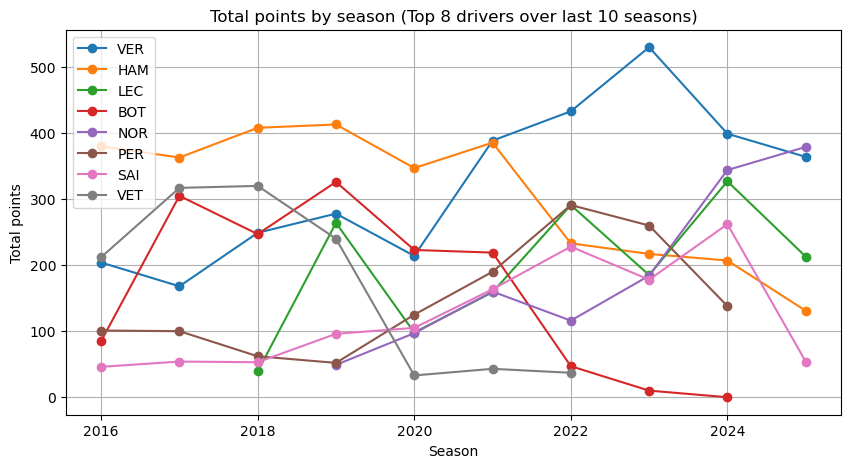

In [118]:
import matplotlib.pyplot as plt

# Sum points per driver and season in the recent window
recent_points = (
    recent_df.groupby(["season", "driver"])["points"]
    .sum()
    .reset_index()
)

# Select top drivers across the last 10 seasons
top_n = 8
top_drivers_overall = (
    recent_points.groupby("driver")["points"]
    .sum()
    .sort_values(ascending=False)
    .head(top_n)
    .index
)

recent_points_top = recent_points[recent_points["driver"].isin(top_drivers_overall)]

plt.figure()
for drv in top_drivers_overall:
    sub = recent_points_top[recent_points_top["driver"] == drv]
    plt.plot(sub["season"], sub["points"], marker="o", label=drv)

plt.xlabel("Season")
plt.ylabel("Total points")
plt.title(f"Total points by season (Top {top_n} drivers over last {last_n_seasons} seasons)")
plt.legend()
plt.show()

## STEP 9 — Grid vs Finish (Last 10 Seasons, Classified Only)

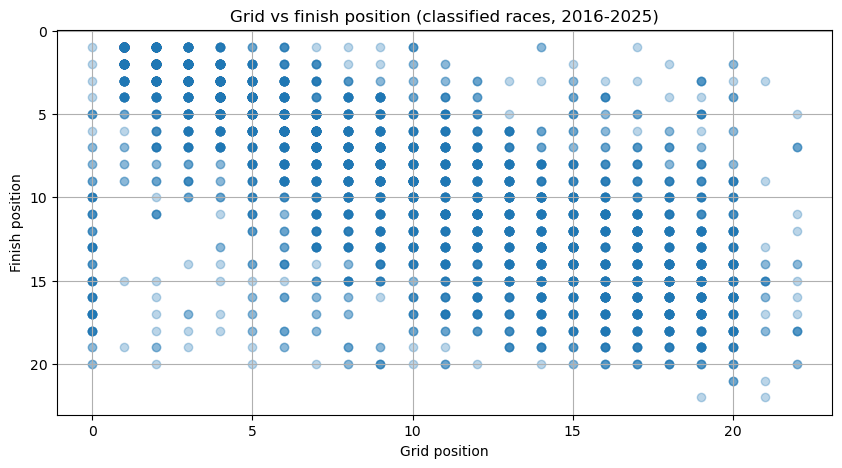

In [119]:
# Use only races where we have a numeric finish position
classified_recent = recent_df[recent_df["finish_position_num"].notna()].copy()

plt.figure()
plt.scatter(
    classified_recent["grid"],
    classified_recent["finish_position_num"],
    alpha=0.3
)
plt.gca().invert_yaxis()
plt.xlabel("Grid position")
plt.ylabel("Finish position")
plt.title(f"Grid vs finish position (classified races, {start_season}-{latest_season})")
plt.show()

## STEP 10 — Team Performance (Last 10 Seasons)

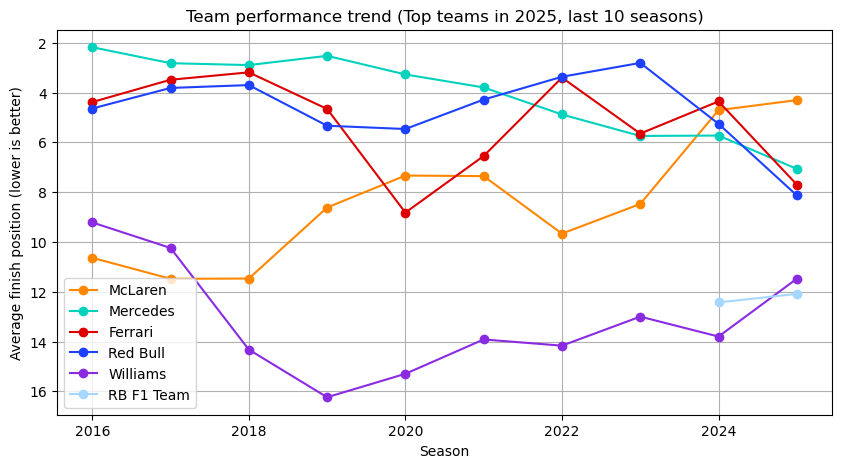

In [120]:
import matplotlib.pyplot as plt

# Use only classified finishes for average position in the recent 10 seasons
classified_recent = recent_df[recent_df["finish_position_num"].notna()].copy()

team_perf = (
    classified_recent.groupby(["season", "team"])["finish_position_num"]
    .mean()
    .reset_index()
)

# Rank teams by average finish in the latest season
latest_season = classified_recent["season"].max()
latest_team_perf = (
    team_perf[team_perf["season"] == latest_season]
    .sort_values("finish_position_num")
)

top_teams = latest_team_perf["team"].head(6).tolist()
team_perf_top = team_perf[team_perf["team"].isin(top_teams)]

# Fixed, clearly distinct colors for the most common top teams
team_colors = {
    "McLaren":      "#FF8700",  # papaya orange
    "Mercedes":     "#00D2BE",  # teal
    "Ferrari":      "#DC0000",  # red
    "Red Bull":     "#1E41FF",  # deep blue / purple
    "Williams":     "#8A2BE2" ,  # dark navy blue
    "RB F1 Team":   "#A6D8FF",  # very light blue
}

plt.figure()

for tm in top_teams:
    sub = team_perf_top[team_perf_top["team"] == tm]

    color = team_colors.get(tm, None)  # fallback to default if not specified

    plt.plot(
        sub["season"],
        sub["finish_position_num"],
        marker="o",
        label=tm,
        color=color,
    )

plt.gca().invert_yaxis()
plt.xlabel("Season")
plt.ylabel("Average finish position (lower is better)")
plt.title(f"Team performance trend (Top teams in {latest_season}, last {last_n_seasons} seasons)")
plt.legend()
plt.show()

## STEP 11 — Summary for Modern-Era EDA

In this section, we focused on the last 10 seasons only, in order to better reflect the current F1 era.

Key points:
- Defined a modern-era subset using the last 10 seasons (`start_season` to `latest_season`).
- Analyzed points distribution for top drivers in the last 10 seasons.
- Investigated the relationship between grid position and finish position in recent years.
- Tracked team performance trends based on average classified finishing position.

These insights will guide the feature engineering and modeling steps for predicting the outcome of the 2025 Abu Dhabi Grand Prix, using only data that is relevant to the current competitive environment.